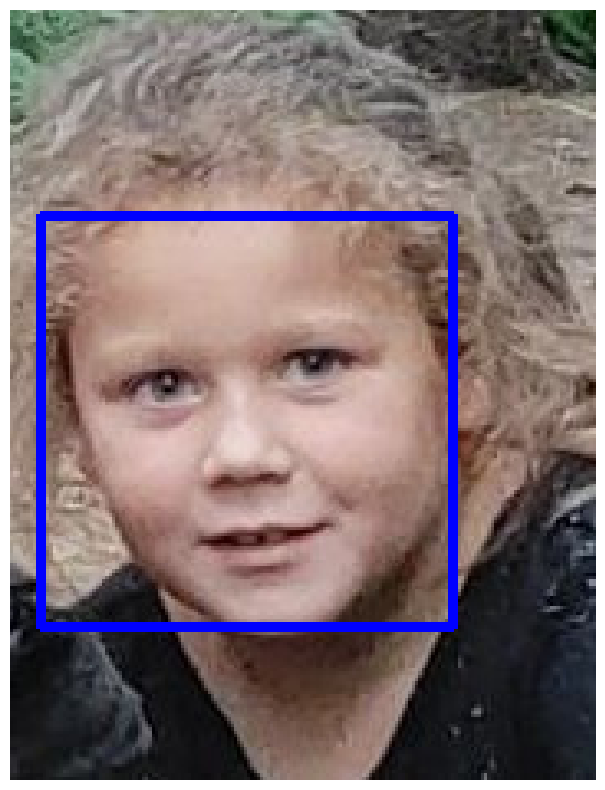

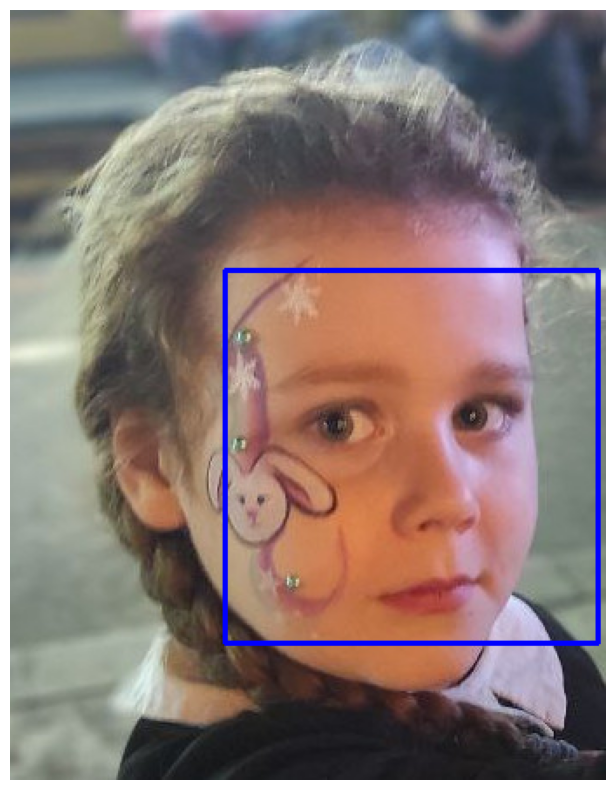

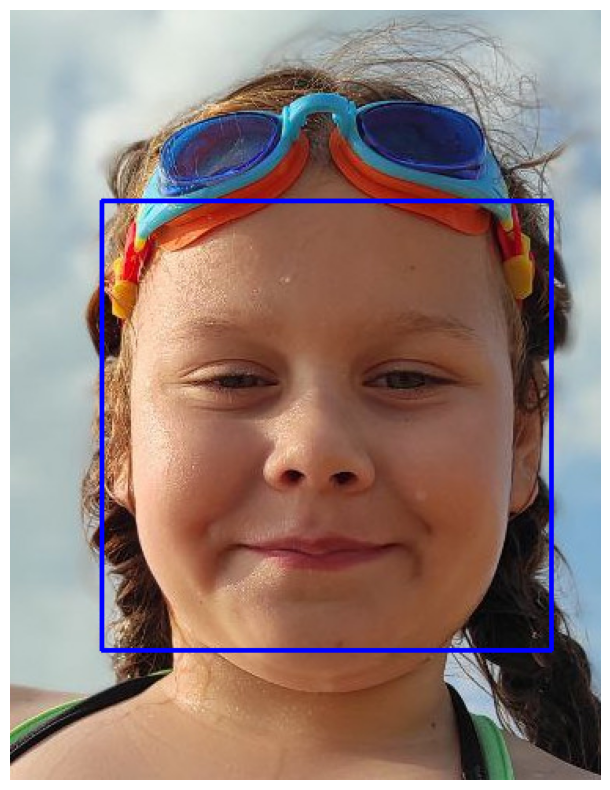

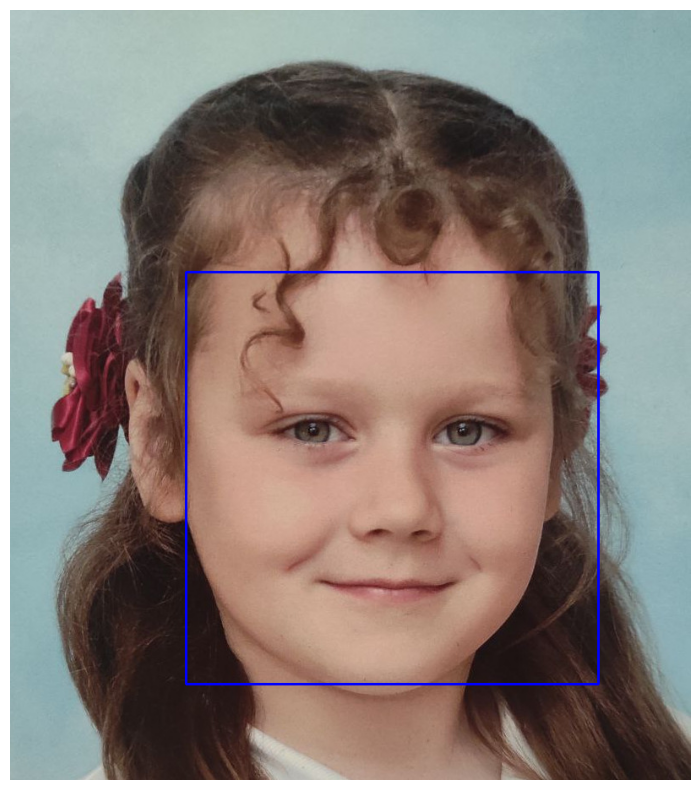

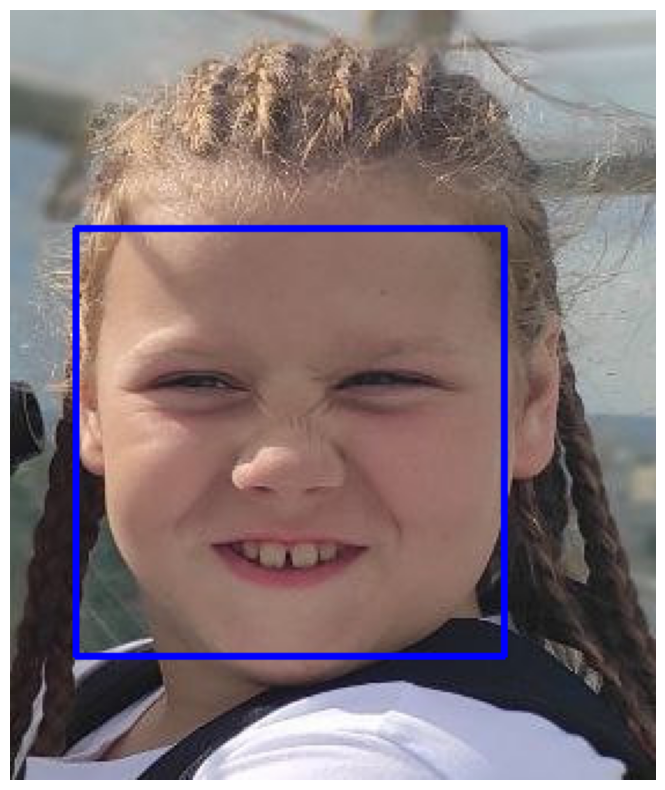

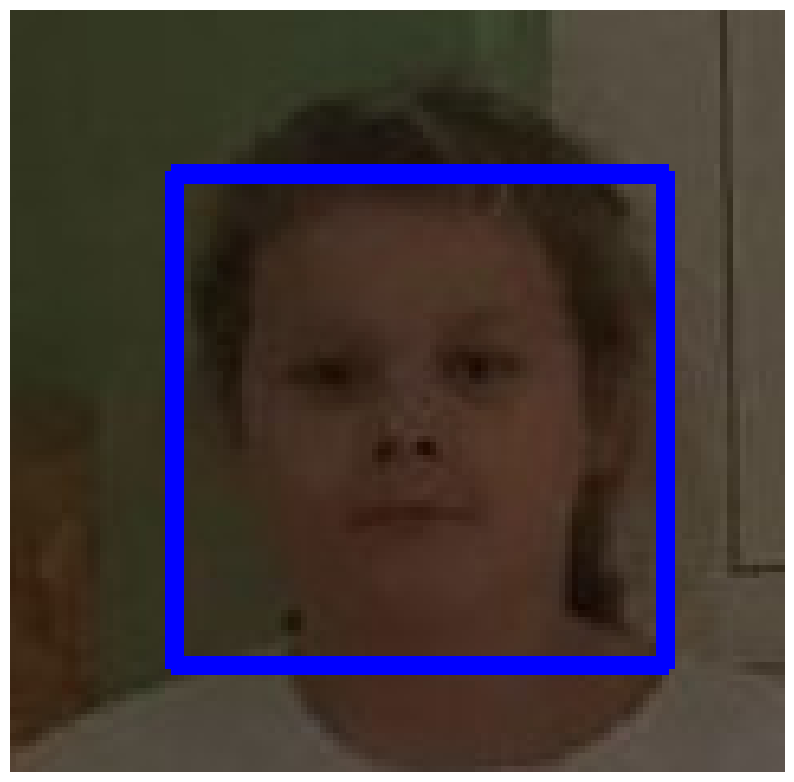

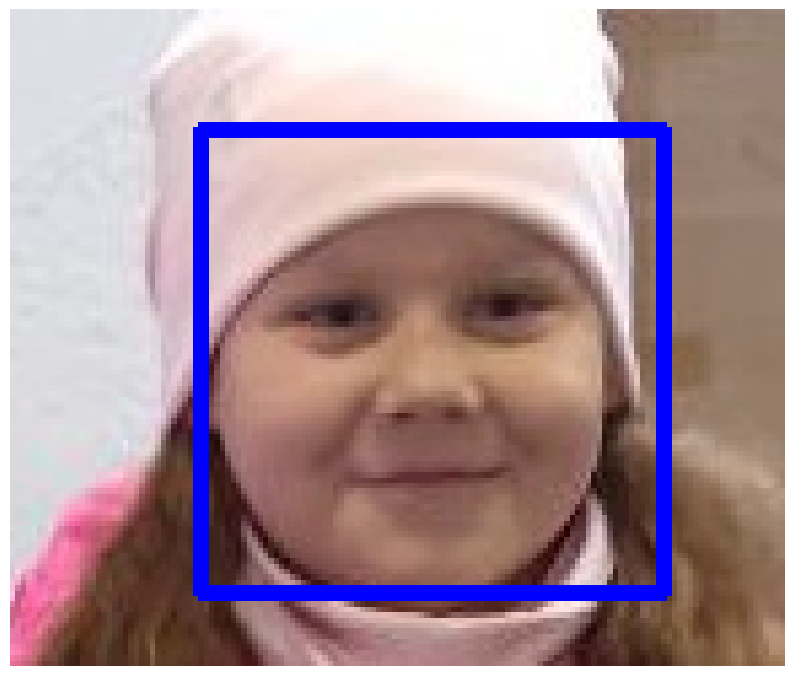

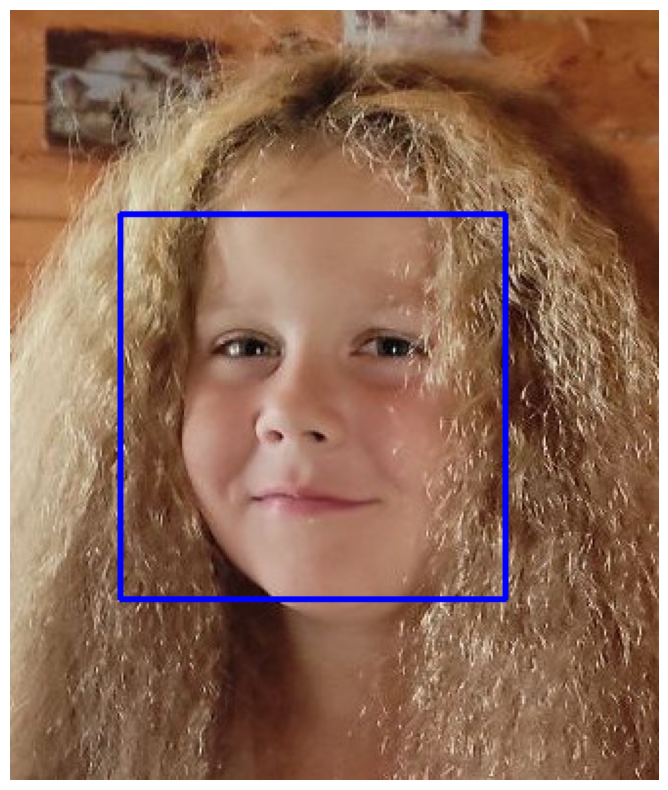

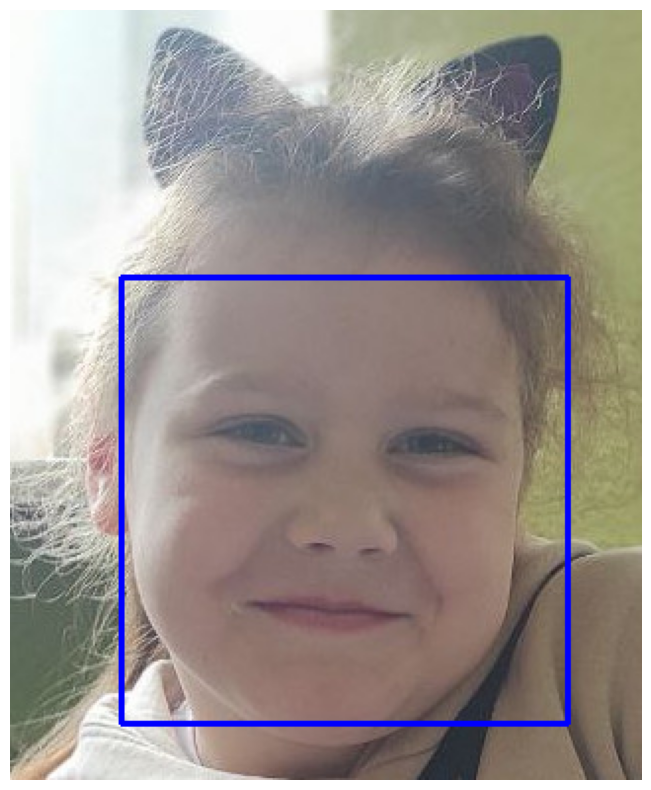

In [27]:
import numpy as np
import os 
import cv2 
from matplotlib import pyplot as plt
import difflib
data_exist = os.listdir('/home/gea/TMS_projects/photo/Sasha') 	    		  #Папка с файлами, которые ищем.


#find_matches(src, template_3)
for file in data_exist:
    
# Загрузка изображения
    image = cv2.imread(r'/home/gea/TMS_projects/photo/Sasha/'+file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Применение размытия
    #image = cv2.GaussianBlur(image, (5, 5), 150)

# Загрузка предварительно обученного каскада Хаара для детектирования лиц
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Детектирование лиц на изображении
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Рисуем прямоугольники вокруг обнаруженных лиц
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Отображение результата с помощью matplotlib
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Отключаем оси координат
    plt.show()

In [4]:
from imutils import paths
import face_recognition
import pickle
import cv2
import os

# в директории Images хранятся папки со всеми изображениями
imagePaths = list(paths.list_images('photo'))
knownEncodings = []
knownNames = []
# перебираем все папки с изображениями
for (i, imagePath) in enumerate(imagePaths):
    # извлекаем имя человека из названия папки
    name = imagePath.split(os.path.sep)[-2]
    # загружаем изображение и конвертируем его из BGR (OpenCV ordering)
    # в dlib ordering (RGB)
    image = cv2.imread(imagePath)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #используем библиотеку Face_recognition для обнаружения лиц
    boxes = face_recognition.face_locations(rgb,model='hog')
    # вычисляем эмбеддинги для каждого лица
    encodings = face_recognition.face_encodings(rgb, boxes)
    # loop over the encodings
    for encoding in encodings:
        knownEncodings.append(encoding)
        knownNames.append(name)
# сохраним эмбеддинги вместе с их именами в формате словаря
data = {"encodings": knownEncodings, "names": knownNames}
# для сохранения данных в файл используем метод pickle
f = open("face_enc", "wb")
f.write(pickle.dumps(data))
f.close()

In [1]:
import face_recognition
import imutils
import pickle
import time
import cv2
import os

# find path of xml file containing haarcascade file 
cascPathface = os.path.dirname(cv2.__file__) + "/data/haarcascade_frontalface_alt2.xml"
# load the harcaascade in the cascade classifier
faceCascade = cv2.CascadeClassifier(cascPathface)
# load the known faces and embeddings saved in last file
data = pickle.loads(open('face_enc', "rb").read())

print("Streaming started")
video_capture = cv2.VideoCapture(0)
# loop over frames from the video file stream
while True:
    # grab the frame from the threaded video stream
    ret, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60), flags=cv2.CASCADE_SCALE_IMAGE)

    # convert the input frame from BGR to RGB 
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # the facial embeddings for face in input
    encodings = face_recognition.face_encodings(rgb)
    names = []
    # loop over the facial embeddings incase
    # we have multiple embeddings for multiple fcaes
    for encoding in encodings:
       # Compare encodings with encodings in data["encodings"]
       # Matches contain array with boolean values and True for the embeddings it matches closely
       # and False for rest
        matches = face_recognition.compare_faces(data["encodings"], encoding)
        # set name =inknown if no encoding matches
        name = "Unknown"
        # check to see if we have found a match
        if True in matches:
            #Find positions at which we get True and store them
            matchedIdxs = [i for (i, b) in enumerate(matches) if b]
            counts = {}
            # loop over the matched indexes and maintain a count for
            # each recognized face face
            for i in matchedIdxs:
                # Check the names at respective indexes we stored in matchedIdxs
                name = data["names"][i]
                # increase count for the name we got
                counts[name] = counts.get(name, 0) + 1
            # set name which has highest count
            name = max(counts, key=counts.get)


        # update the list of names
        names.append(name)
        # loop over the recognized faces
        for ((x, y, w, h), name) in zip(faces, names):
            # rescale the face coordinates
            # draw the predicted face name on the image
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, name, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
    cv2.imshow("Frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()

Streaming started
